# Workshop 3.1: Fine-Grained Pruning for Efficient Inference

## Learning Objectives
By the end of this notebook, you will:
- Understand what fine-grained (unstructured) pruning is and its importance for edge AI
- Analyze weight distributions before pruning using histograms
- Learn magnitude-based pruning strategies
- Implement unstructured magnitude pruning with PyTorch
- Compare model sparsity, speed, and accuracy trade-offs
- Visualize pruning effects on network parameters

## What is Fine-Grained Pruning?
Fine-grained pruning (also called unstructured pruning) removes individual weights from neural networks based on their magnitude. Unlike structured pruning that removes entire channels or filters, fine-grained pruning can remove any weight regardless of its position, creating sparse networks with irregular patterns.

**Key Characteristics:**
- **Individual weight removal** - Any weight can be pruned
- **Magnitude-based selection** - Smallest weights are removed first
- **Higher sparsity potential** - Can achieve very high compression ratios
- **Irregular sparsity patterns** - Requires special hardware/software for speedup

Paper: https://arxiv.org/pdf/1506.02626

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
from torchvision import models
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import copy
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## Step 1: Load and Prepare CIFAR-10 Dataset

In [2]:
# Define transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Classes: {classes}")

Training samples: 50000
Test samples: 10000
Classes: ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


## Step 2: Load and Modify MobileNetV2 for Pruning

In [3]:
# Load and modify MobileNetV2 for CIFAR-10 pruning
def create_mobilenetv2_cifar10(num_classes=10, pretrained=True):
    """
    Create MobileNetV2 adapted for CIFAR-10
    CIFAR-10 images are 32x32, smaller than ImageNet's 224x224
    """
    # Load pre-trained MobileNetV2
    model = models.mobilenet_v2(pretrained=pretrained)
    
    # Modify the first convolution layer for smaller input size
    # Original: stride=2, now stride=1 to preserve spatial dimensions
    model.features[0][0] = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
    
    # Modify classifier for CIFAR-10 (10 classes instead of 1000)
    model.classifier[1] = nn.Linear(model.last_channel, num_classes)
    
    return model

# Create model instance
model = create_mobilenetv2_cifar10(num_classes=10, pretrained=True).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"MobileNetV2 loaded with {total_params:,} total parameters")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model adapted for CIFAR-10 and ready for pruning")

/home/exouser/Documents/Workshop/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/exouser/Documents/Workshop/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2 loaded with 2,236,682 total parameters
Trainable parameters: 2,236,682
Model adapted for CIFAR-10 and ready for pruning


## Step 3: Train the Original Model

In [4]:
def train_model(model, trainloader, testloader, epochs=8, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    train_losses = []
    train_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop with progress bar
        pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (inputs, labels) in enumerate(pbar):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.3f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

# Train the model
print("Training original model...")
train_losses, train_accuracies = train_model(model, trainloader, testloader, epochs=10)

Training original model...


Epoch 1/10: 100%|██████████| 391/391 [00:09<00:00, 39.67it/s, Loss=0.933, Acc=67.65%]


Epoch 1: Loss: 0.9331, Accuracy: 67.65%


Epoch 2/10: 100%|██████████| 391/391 [00:08<00:00, 44.82it/s, Loss=0.576, Acc=80.31%]


Epoch 2: Loss: 0.5756, Accuracy: 80.31%


Epoch 3/10: 100%|██████████| 391/391 [00:09<00:00, 43.26it/s, Loss=0.488, Acc=83.27%]


Epoch 3: Loss: 0.4880, Accuracy: 83.27%


Epoch 4/10: 100%|██████████| 391/391 [00:08<00:00, 44.32it/s, Loss=0.429, Acc=85.31%]


Epoch 4: Loss: 0.4290, Accuracy: 85.31%


Epoch 5/10: 100%|██████████| 391/391 [00:08<00:00, 45.21it/s, Loss=0.393, Acc=86.58%]


Epoch 5: Loss: 0.3925, Accuracy: 86.58%


Epoch 6/10: 100%|██████████| 391/391 [00:08<00:00, 44.96it/s, Loss=0.370, Acc=87.47%]


Epoch 6: Loss: 0.3696, Accuracy: 87.47%


Epoch 7/10: 100%|██████████| 391/391 [00:08<00:00, 44.72it/s, Loss=0.355, Acc=87.89%]


Epoch 7: Loss: 0.3549, Accuracy: 87.89%


Epoch 8/10: 100%|██████████| 391/391 [00:08<00:00, 44.56it/s, Loss=0.338, Acc=88.41%]


Epoch 8: Loss: 0.3380, Accuracy: 88.41%


Epoch 9/10: 100%|██████████| 391/391 [00:08<00:00, 45.21it/s, Loss=0.321, Acc=89.07%]


Epoch 9: Loss: 0.3213, Accuracy: 89.07%


Epoch 10/10: 100%|██████████| 391/391 [00:08<00:00, 44.57it/s, Loss=0.309, Acc=89.52%]

Epoch 10: Loss: 0.3086, Accuracy: 89.52%


## Step 4: Analyze Weight Distributions Before Pruning

Before applying pruning, let's examine the weight distributions in our trained model. This helps us understand:
- How weights are distributed across different layers
- Which weights are candidates for removal (small magnitude)
- The impact of pruning on different layer types

In [5]:
# Helper functions for weight analysis
def collect_layer_weights(model):
    """
    Collect weights from different layer types for analysis
    """
    conv_weights = []
    linear_weights = []
    layer_info = []
    
    for name, module in model.named_modules():
        if isinstance(module, nn.Conv2d):
            weights = module.weight.data.cpu().flatten().numpy()
            conv_weights.extend(weights)
            layer_info.append({
                'name': name,
                'type': 'Conv2d',
                'shape': list(module.weight.shape),
                'total_params': module.weight.numel(),
                'mean_abs': np.mean(np.abs(weights)),
                'std': np.std(weights)
            })
        elif isinstance(module, nn.Linear):
            weights = module.weight.data.cpu().flatten().numpy()
            linear_weights.extend(weights)
            layer_info.append({
                'name': name,
                'type': 'Linear',
                'shape': list(module.weight.shape),
                'total_params': module.weight.numel(),
                'mean_abs': np.mean(np.abs(weights)),
                'std': np.std(weights)
            })
    
    return conv_weights, linear_weights, layer_info

def print_weight_statistics(layer_info, all_weights):
    """
    Print detailed weight statistics in a formatted table
    """
    print("\n" + "="*80)
    print("WEIGHT DISTRIBUTION ANALYSIS")
    print("="*80)
    print(f"{'Layer':<25} {'Type':<8} {'Shape':<15} {'Params':<10} {'Mean |W|':<10} {'Std':<10}")
    print("-" * 80)
    
    for info in layer_info:
        shape_str = f"{info['shape']}"
        if len(shape_str) > 14:
            shape_str = shape_str[:11] + "..."
        print(f"{info['name']:<25} {info['type']:<8} {shape_str:<15} "
              f"{info['total_params']:<10} {info['mean_abs']:<10.4f} {info['std']:<10.4f}")
    
    abs_weights = np.abs(all_weights)
    print(f"\nOverall Statistics:")
    print(f"Total weights: {len(all_weights):,}")
    print(f"Mean absolute weight: {np.mean(abs_weights):.4f}")
    print(f"Median absolute weight: {np.median(abs_weights):.4f}")
    print(f"Weights near zero (|w| < 0.001): {(abs_weights < 0.001).sum():,} ({(abs_weights < 0.001).mean()*100:.1f}%)")

In [6]:
# Collect weights from the trained model
print("Collecting weights from different layer types...")
conv_weights, linear_weights, layer_info = collect_layer_weights(model)
all_weights = conv_weights + linear_weights

print(f"Found {len(layer_info)} layers with weights:")
print(f"  - Conv2d layers: {len([info for info in layer_info if info['type'] == 'Conv2d'])}")
print(f"  - Linear layers: {len([info for info in layer_info if info['type'] == 'Linear'])}")
print(f"  - Total weights: {len(all_weights):,}")

# Print detailed statistics
print_weight_statistics(layer_info, all_weights)

Found 53 layers with weights:
  - Conv2d layers: 52
  - Linear layers: 1
  - Total weights: 2,202,560

WEIGHT DISTRIBUTION ANALYSIS
Layer                     Type     Shape           Params     Mean |W|   Std       
--------------------------------------------------------------------------------
features.0.0              Conv2d   [32, 3, 3, 3]   864        0.0792     0.1075    
features.1.conv.0.0       Conv2d   [32, 1, 3, 3]   288        0.2450     0.4663    
features.1.conv.1         Conv2d   [16, 32, 1, 1]  512        0.1477     0.2220    
features.2.conv.0.0       Conv2d   [96, 16, 1, 1]  1536       0.1357     0.1741    
features.2.conv.1.0       Conv2d   [96, 1, 3, 3]   864        0.1318     0.1617    
features.2.conv.2         Conv2d   [24, 96, 1, 1]  2304       0.1265     0.1643    
features.3.conv.0.0       Conv2d   [144, 24, 1...  3456       0.0962     0.1224    
features.3.conv.1.0       Conv2d   [144, 1, 3, 3]  1296       0.1345     0.1847    
features.3.conv.2         Conv2

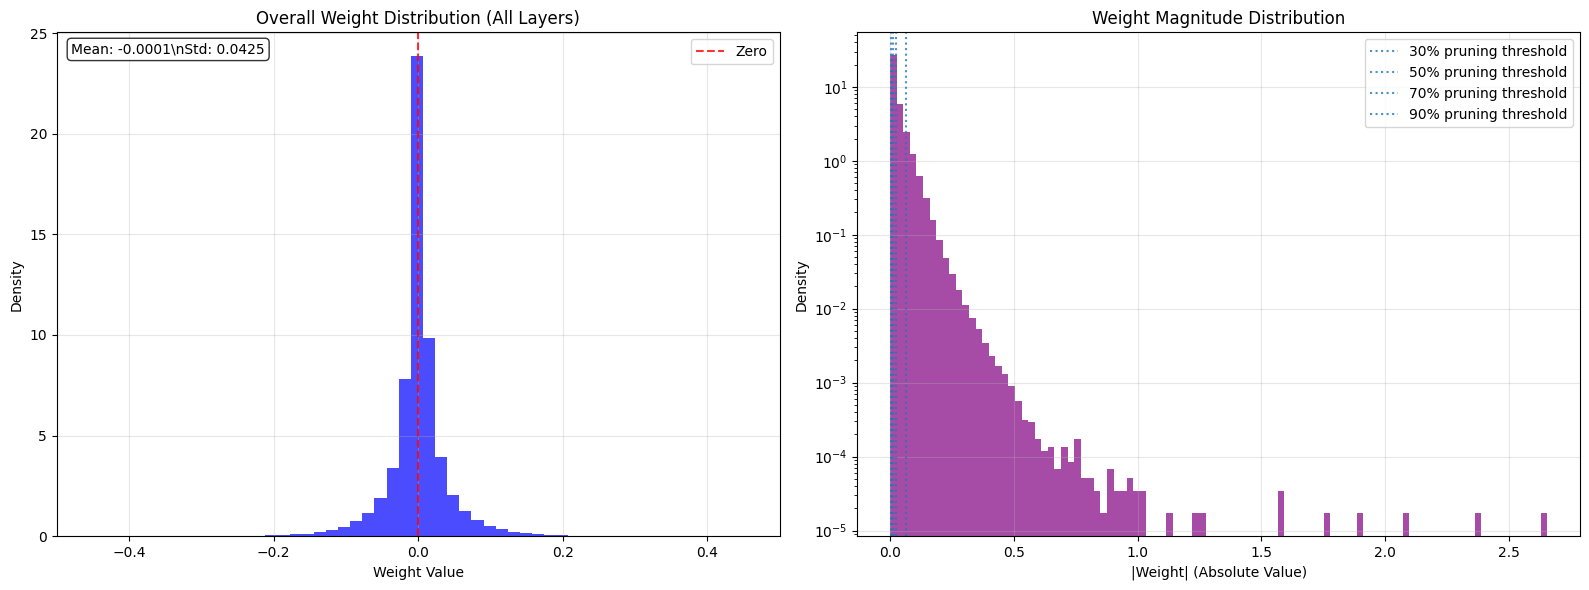

In [7]:
# Create comprehensive weight distribution visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. Overall weight distribution
ax1.hist(all_weights, bins=300, alpha=0.7, color='blue', density=True)
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.8, label='Zero')
ax1.set_xlabel('Weight Value')
ax1.set_ylabel('Density')
ax1.set_title('Overall Weight Distribution (All Layers)')
ax1.set_xlim(-0.5, 0.5)  # Focus on the sharp distribution around zero
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add statistics
mean_weight = np.mean(all_weights)
std_weight = np.std(all_weights)
ax1.text(0.02, 0.98, f'Mean: {mean_weight:.4f}\\nStd: {std_weight:.4f}', 
         transform=ax1.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 2. Weight magnitude distribution with pruning thresholds
abs_weights = np.abs(all_weights)
ax2.hist(abs_weights, bins=100, alpha=0.7, color='purple', density=True)
ax2.set_xlabel('|Weight| (Absolute Value)')
ax2.set_ylabel('Density')
ax2.set_title('Weight Magnitude Distribution')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# Add pruning threshold lines for different ratios
sorted_abs_weights = np.sort(abs_weights)
for ratio in [0.3, 0.5, 0.7, 0.9]:
    threshold = sorted_abs_weights[int(len(sorted_abs_weights) * ratio)]
    ax2.axvline(x=threshold, linestyle=':', alpha=0.8, 
               label=f'{ratio:.0%} pruning threshold')
ax2.legend()

plt.tight_layout()
plt.show()

In [8]:
# Helper functions for model evaluation and parameter counting
def evaluate_model(model, testloader, model_name="Model"):
    """
    Evaluate model accuracy and measure inference time
    """
    model.eval()
    correct = 0
    total = 0
    
    # Measure inference time
    start_time = time.time()
    
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc=f'Evaluating {model_name}'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    end_time = time.time()
    inference_time = end_time - start_time
    
    accuracy = 100. * correct / total
    print(f'{model_name} - Accuracy: {accuracy:.2f}%, Inference Time: {inference_time:.2f}s')
    
    return accuracy, inference_time

def count_parameters(model):
    """Count total trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def count_nonzero_parameters(model):
    """Count non-zero parameters (useful for pruned models)"""
    nonzero_params = 0
    
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            # Check if the module has been pruned (has weight_mask)
            if hasattr(module, 'weight_mask'):
                # Count non-zero elements in the effective weight (weight * mask)
                effective_weight = module.weight * module.weight_mask
                nonzero_params += (effective_weight != 0).sum().item()
            else:
                # If not pruned, count all non-zero parameters
                nonzero_params += (module.weight != 0).sum().item()
            
            # Also count bias if it exists
            if hasattr(module, 'bias') and module.bias is not None:
                nonzero_params += (module.bias != 0).sum().item()
    
    return nonzero_params

def calculate_sparsity(model):
    """Calculate sparsity percentage of a model"""
    total_params = 0
    zero_params = 0
    
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            # Check if the module has been pruned (has weight_mask)
            if hasattr(module, 'weight_mask'):
                # Count based on effective weight (weight * mask)
                effective_weight = module.weight * module.weight_mask
                total_params += effective_weight.numel()
                zero_params += (effective_weight == 0).sum().item()
            else:
                # If not pruned, count normally
                total_params += module.weight.numel()
                zero_params += (module.weight == 0).sum().item()
    
    sparsity = 100.0 * zero_params / total_params if total_params > 0 else 0.0
    return sparsity

def apply_fine_grained_pruning(model, pruning_ratio):
    """
    Apply fine-grained (unstructured) pruning to all Conv2d and Linear layers
    """
    print(f"Applying {pruning_ratio:.0%} fine-grained pruning...")
    
    # Apply pruning to all Conv2d and Linear layers
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prune.l1_unstructured(module, name='weight', amount=pruning_ratio)
            print(f"  Pruned layer: {name}")
    
    print(f"Fine-grained pruning complete - {pruning_ratio:.0%} of weights removed")
    return model

def fine_tune_pruned_model(pruned_model, trainloader, testloader, epochs=3, learning_rate=0.0001):
    """
    Fine-tune a pruned model to recover accuracy
    """
    print(f"Fine-tuning pruned model for {epochs} epochs with learning rate {learning_rate}")
    
    # Set up optimizer and loss function
    optimizer = optim.Adam(pruned_model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    # Track progress
    train_losses = []
    train_accuracies = []
    
    pruned_model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        progress_bar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = pruned_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{running_loss/(len(trainloader)):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })
        
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100. * correct / total
        
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_accuracy:.2f}%')
    
    print(f"Fine-tuning complete! Final training accuracy: {train_accuracies[-1]:.2f}%")
    
    return pruned_model

In [9]:
# Evaluate original model performance (baseline)
print("Evaluating original model performance...")
original_accuracy, original_time = evaluate_model(model, testloader, "Original")
original_params = count_parameters(model)

print(f"\nOriginal Model Summary:")
print(f"  Total parameters: {original_params:,}")
print(f"  Accuracy: {original_accuracy:.2f}%")
print(f"  Inference time: {original_time:.2f}s")
print(f"  This will be our baseline for comparison")

Evaluating original model performance...


Evaluating Original: 100%|██████████| 100/100 [00:01<00:00, 80.75it/s]

Original - Accuracy: 87.48%, Inference Time: 1.24s

Original Model Summary:
  Total parameters: 2,236,682
  Accuracy: 87.48%
  Inference time: 1.24s
  This will be our baseline for comparison


## Step 5: Hands-On Challenge - Optimize Model for Edge Deployment

### Challenge Objective
Your task is to create a compressed model that maintains **at least 85% accuracy** after fine-tuning. This simulates real-world scenarios where you need to deploy AI models on resource-constrained devices.

### Challenge Requirements
1. **Pruning Strategy**: Apply fine-grained pruning with a single pruning ratio to the entire model
2. **Target Accuracy**: Final model must achieve ≥85% accuracy after fine-tuning
3. **Approach**: Prune → Fine-tune → Evaluate
4. **Analysis**: Visualize the impact of pruning on model performance

### Challenge Steps
1. **Choose Pruning Ratio**: Select a global pruning ratio (e.g., 50%, 70%, 80%)
2. **Apply Pruning**: Remove weights uniformly across all layers
3. **Fine-tune Model**: Recover accuracy through targeted training
4. **Evaluate Results**: Measure final accuracy, sparsity, and compression

### Success Metrics
- **Primary**: Accuracy ≥ 85% after fine-tuning
- **Secondary**: Maximum sparsity/compression achieved
- **Bonus**: Maintain inference speed improvements

In [10]:
# Challenge Setup: Simple pruning challenge with single ratio

def evaluate_challenge_model(model, testloader, model_name, target_accuracy=85.0):
    """
    Evaluate if a model meets the challenge requirements
    """
    accuracy, inference_time = evaluate_model(model, testloader, model_name)
    sparsity = calculate_sparsity(model)
    params = count_nonzero_parameters(model)
    
    meets_requirement = accuracy >= target_accuracy
    status = "PASS" if meets_requirement else "FAIL"
    
    print(f"\n{'='*60}")
    print(f"CHALLENGE EVALUATION: {model_name}")
    print(f"{'='*60}")
    print(f"Accuracy: {accuracy:.2f}% (Target: ≥{target_accuracy:.0f}%) - {status}")
    print(f"Sparsity: {sparsity:.1f}% (Higher is better)")
    print(f"Active Parameters: {params:,} (Lower is better)")
    print(f"Inference Time: {inference_time:.2f}s (Lower is better)")
    
    return {
        'accuracy': accuracy,
        'sparsity': sparsity,
        'params': params,
        'inference_time': inference_time,
        'meets_requirement': meets_requirement
    }

def create_pruning_visualization(original_result, pruned_result, finetuned_result, pruning_ratio):
    """
    Create visualization comparing original, pruned, and fine-tuned models
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Accuracy comparison
    models = ['Original', f'{pruning_ratio:.0%} Pruned', f'{pruning_ratio:.0%} Pruned\n+ Fine-tuned']
    accuracies = [original_result['accuracy'], pruned_result['accuracy'], finetuned_result['accuracy']]
    colors = ['blue', 'red', 'green']
    
    bars1 = ax1.bar(models, accuracies, color=colors, alpha=0.7)
    ax1.axhline(y=85, color='red', linestyle='--', alpha=0.8, label='Target (85%)')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_ylim(0, 100)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, acc in zip(bars1, accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Plot 2: Model size comparison
    params = [original_result['params'], pruned_result['params'], finetuned_result['params']]
    params_mb = [p / 1e6 for p in params]  # Convert to millions
    
    bars2 = ax2.bar(models, params_mb, color=colors, alpha=0.7)
    ax2.set_ylabel('Parameters (Millions)')
    ax2.set_title('Model Size Comparison')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, param in zip(bars2, params_mb):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
                f'{param:.2f}M', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print compression stats
    size_reduction = ((original_result['params'] - finetuned_result['params']) / original_result['params']) * 100
    print(f"\nCOMPRESSION SUMMARY:")
    print(f"  • Original model: {original_result['params']:,} parameters")
    print(f"  • Final model: {finetuned_result['params']:,} parameters")
    print(f"  • Size reduction: {size_reduction:.1f}%")
    print(f"  • Sparsity achieved: {finetuned_result['sparsity']:.1f}%")

### Important Note: Understanding Fine-Grained Pruning

**Why does a pruned model still have the same parameter count?**

Fine-grained (unstructured) pruning works differently than you might expect:

1. **Weights are set to zero, not removed**: Pruning sets individual weights to zero but keeps the same model structure
2. **Parameter count stays the same**: The model still has the same number of parameters, but many are zero
3. **Sparsity is the key metric**: We measure "sparsity" (percentage of zero weights) rather than parameter reduction
4. **Benefits come from sparsity**: Sparse models can be accelerated with specialized hardware or software

**Key Metrics to Track:**
- **Total Parameters**: Always the same (model structure unchanged)
- **Non-zero Parameters**: Actual "active" parameters doing computation
- **Sparsity**: Percentage of weights that are zero
- **Effective Compression**: Based on non-zero parameters

**Example**: A 70% pruned model has:
- Same total parameters as original
- 70% of weights set to zero (70% sparsity)
- Only 30% of weights are non-zero (30% effective size)

EDGE DEPLOYMENT CHALLENGE
Goal: Compress model to 85% accuracy after fine-tuning

Step 1: Baseline Assessment


Evaluating Original Model: 100%|██████████| 100/100 [00:01<00:00, 84.67it/s]


Original Model - Accuracy: 87.48%, Inference Time: 1.18s

CHALLENGE EVALUATION: Original Model
Accuracy: 87.48% (Target: ≥85%) - PASS
Sparsity: 0.0% (Higher is better)
Active Parameters: 2,202,570 (Lower is better)
Inference Time: 1.18s (Lower is better)

Step 2: Applying 70% pruning to entire model
This will remove 70% of all weights uniformly across layers
Applying 70% fine-grained pruning...
  Pruned layer: features.0.0
  Pruned layer: features.1.conv.0.0
  Pruned layer: features.1.conv.1
  Pruned layer: features.2.conv.0.0
  Pruned layer: features.2.conv.1.0
  Pruned layer: features.2.conv.2
  Pruned layer: features.3.conv.0.0
  Pruned layer: features.3.conv.1.0
  Pruned layer: features.3.conv.2
  Pruned layer: features.4.conv.0.0
  Pruned layer: features.4.conv.1.0
  Pruned layer: features.4.conv.2
  Pruned layer: features.5.conv.0.0
  Pruned layer: features.5.conv.1.0
  Pruned layer: features.5.conv.2
  Pruned layer: features.6.conv.0.0
  Pruned layer: features.6.conv.1.0
  Prune

Evaluating 70% Pruned Model: 100%|██████████| 100/100 [00:01<00:00, 84.35it/s]


70% Pruned Model - Accuracy: 10.00%, Inference Time: 1.19s

CHALLENGE EVALUATION: 70% Pruned Model
Accuracy: 10.00% (Target: ≥85%) - FAIL
Sparsity: 70.0% (Higher is better)
Active Parameters: 660,778 (Lower is better)
Inference Time: 1.19s (Lower is better)

Pruning Impact:
  • Accuracy drop: 77.48%
  • Sparsity achieved: 70.0%
  • Parameters reduced: 1,541,792

Step 3: Fine-tuning the 70% pruned model
Attempting to recover accuracy through fine-tuning...
Fine-tuning pruned model for 5 epochs with learning rate 0.0001


Epoch 1/5: 100%|██████████| 391/391 [00:10<00:00, 38.56it/s, Loss=1.0906, Acc=63.18%]


Epoch 1/5: Loss = 1.0906, Accuracy = 63.18%


Epoch 2/5: 100%|██████████| 391/391 [00:09<00:00, 39.17it/s, Loss=0.7266, Acc=74.86%]


Epoch 2/5: Loss = 0.7266, Accuracy = 74.86%


Epoch 3/5: 100%|██████████| 391/391 [00:10<00:00, 38.60it/s, Loss=0.6170, Acc=78.40%]


Epoch 3/5: Loss = 0.6170, Accuracy = 78.40%


Epoch 4/5: 100%|██████████| 391/391 [00:09<00:00, 39.37it/s, Loss=0.5539, Acc=80.77%]


Epoch 4/5: Loss = 0.5539, Accuracy = 80.77%


Epoch 5/5: 100%|██████████| 391/391 [00:10<00:00, 38.95it/s, Loss=0.5093, Acc=82.35%]


Epoch 5/5: Loss = 0.5093, Accuracy = 82.35%
Fine-tuning complete! Final training accuracy: 82.35%


Evaluating 70% Pruned + Fine-tuned: 100%|██████████| 100/100 [00:01<00:00, 84.08it/s]


70% Pruned + Fine-tuned - Accuracy: 82.79%, Inference Time: 1.19s

CHALLENGE EVALUATION: 70% Pruned + Fine-tuned
Accuracy: 82.79% (Target: ≥85%) - FAIL
Sparsity: 70.0% (Higher is better)
Active Parameters: 660,778 (Lower is better)
Inference Time: 1.19s (Lower is better)

Fine-tuning Results:
  • Accuracy recovery: +72.79%
  • Final accuracy: 82.79%
  • Challenge status: FAILED

Step 4: Results Visualization and Analysis


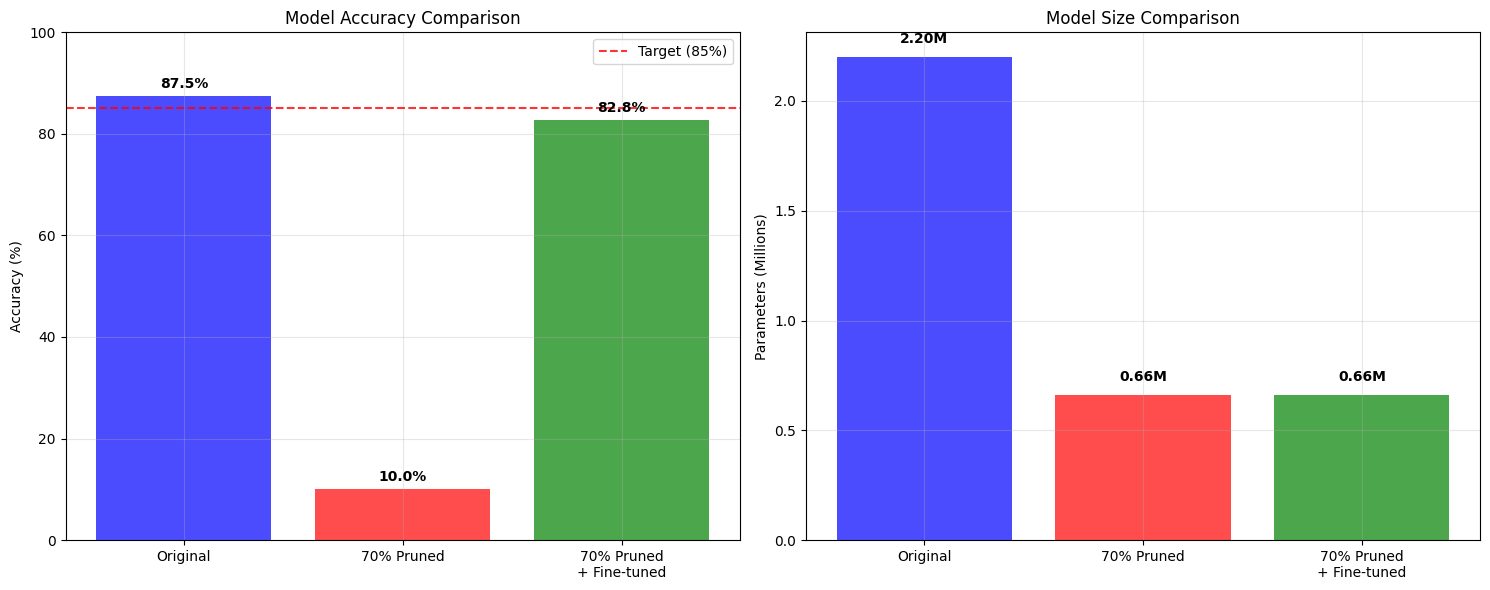


COMPRESSION SUMMARY:
  • Original model: 2,202,570 parameters
  • Final model: 660,778 parameters
  • Size reduction: 70.0%
  • Sparsity achieved: 70.0%


In [11]:
# CHALLENGE IMPLEMENTATION - Single Pruning Ratio Approach

print("EDGE DEPLOYMENT CHALLENGE")
print("="*50)
print("Goal: Compress model to 85% accuracy after fine-tuning")
print("="*50)

# Step 1: Evaluate baseline model
print("\nStep 1: Baseline Assessment")
original_result = evaluate_challenge_model(model, testloader, "Original Model", target_accuracy=85.0)

# Step 2: Choose pruning ratio and apply pruning
# You can modify this ratio to experiment with different compression levels
PRUNING_RATIO = 0.7  # 70% of weights will be removed

print(f"\nStep 2: Applying {PRUNING_RATIO:.0%} pruning to entire model")
print(f"This will remove {PRUNING_RATIO:.0%} of all weights uniformly across layers")

# Create pruned model
pruned_model = apply_fine_grained_pruning(copy.deepcopy(model), PRUNING_RATIO)

# Evaluate pruned model
pruned_result = evaluate_challenge_model(pruned_model, testloader, f"{PRUNING_RATIO:.0%} Pruned Model", target_accuracy=85.0)

# Calculate accuracy drop from pruning
accuracy_drop = original_result['accuracy'] - pruned_result['accuracy']
print(f"\nPruning Impact:")
print(f"  • Accuracy drop: {accuracy_drop:.2f}%")
print(f"  • Sparsity achieved: {pruned_result['sparsity']:.1f}%")
print(f"  • Parameters reduced: {original_result['params'] - pruned_result['params']:,}")

# Step 3: Fine-tune the pruned model
print(f"\nStep 3: Fine-tuning the {PRUNING_RATIO:.0%} pruned model")
print("Attempting to recover accuracy through fine-tuning...")

# Fine-tune the pruned model
finetuned_model = fine_tune_pruned_model(
    copy.deepcopy(pruned_model), 
    trainloader, 
    testloader, 
    epochs=5,
    learning_rate=0.0001
)

# Evaluate fine-tuned model
finetuned_result = evaluate_challenge_model(finetuned_model, testloader, f"{PRUNING_RATIO:.0%} Pruned + Fine-tuned", target_accuracy=85.0)

# Calculate recovery
recovery = finetuned_result['accuracy'] - pruned_result['accuracy']
print(f"\nFine-tuning Results:")
print(f"  • Accuracy recovery: +{recovery:.2f}%")
print(f"  • Final accuracy: {finetuned_result['accuracy']:.2f}%")
print(f"  • Challenge status: {'SUCCESS' if finetuned_result['meets_requirement'] else 'FAILED'}")

# Step 4: Create visualization and final analysis
print(f"\nStep 4: Results Visualization and Analysis")
create_pruning_visualization(original_result, pruned_result, finetuned_result, PRUNING_RATIO)

In [12]:
# Assuming the existence of these functions from the previous context
# - apply_fine_grained_pruning(model, ratio)
# - evaluate_challenge_model(model, testloader, description, target_accuracy)

# Function to visualize pruning effects on specific layers
def visualize_pruning_effect(original_model, pruned_model, layer_name="classifier.1"):
    """
    Visualize the effect of pruning on a specific layer's weights
    """
    print(f"Visualizing pruning effects on layer: {layer_name}")
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 10))
    
    # Get weights from the specified layer
    original_layer = dict(original_model.named_modules())[layer_name]
    pruned_layer = dict(pruned_model.named_modules())[layer_name]
    
    original_weights = original_layer.weight.data.cpu().flatten().numpy()
    
    # Get pruned weights (considering the mask)
    if hasattr(pruned_layer, 'weight_mask'):
        pruned_weights = pruned_layer.weight.data.cpu().flatten().numpy()
        mask = pruned_layer.weight_mask.data.cpu().flatten().numpy()
        pruned_weights_masked = pruned_weights * mask
    else:
        pruned_weights_masked = pruned_layer.weight.data.cpu().flatten().numpy()
        mask = np.ones_like(pruned_weights_masked)
    
    # 1. Original weights histogram
    ax1.hist(original_weights, bins=50, alpha=0.7, color='blue', density=True)
    ax1.set_xlabel('Weight Value')
    ax1.set_ylabel('Density')
    ax1.set_title(f'Original Weights Distribution\\n({layer_name})')
    ax1.grid(True, alpha=0.3)
    ax1.axvline(x=0, color='red', linestyle='--', alpha=0.8)
    
    # 2. Pruned weights histogram (only non-zero)
    non_zero_weights = pruned_weights_masked[pruned_weights_masked != 0]
    ax2.hist(non_zero_weights, bins=50, alpha=0.7, color='orange', density=True)
    ax2.set_xlabel('Weight Value')
    ax2.set_ylabel('Density')
    ax2.set_title(f'Remaining Weights After Pruning\\n({layer_name})')
    ax2.grid(True, alpha=0.3)
    ax2.axvline(x=0, color='red', linestyle='--', alpha=0.8)
    
    # 3. Comparison of original vs pruned
    ax3.hist(original_weights, bins=50, alpha=0.6, label='Original', color='blue', density=True)
    ax3.hist(non_zero_weights, bins=50, alpha=0.6, label='Pruned (non-zero)', color='orange', density=True)
    ax3.set_xlabel('Weight Value')
    ax3.set_ylabel('Density')
    ax3.set_title(f'Weight Distribution Comparison\\n({layer_name})')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Pruning mask visualization
    if len(original_layer.weight.shape) == 4:  # Conv2d layer
        mask_2d = mask.reshape(original_layer.weight.shape)
        im = ax4.imshow(mask_2d[0, 0], cmap='RdYlBu', vmin=0, vmax=1)
        ax4.set_title(f'Pruning Mask (First Channel)\\n({layer_name})')
        plt.colorbar(im, ax=ax4, label='Mask Value (0=Pruned, 1=Kept)')
    else:  # Linear layer
        mask_2d = mask.reshape(original_layer.weight.shape)
        im = ax4.imshow(mask_2d, cmap='RdYlBu', vmin=0, vmax=1, aspect='auto')
        ax4.set_title(f'Pruning Mask\\n({layer_name})')
        ax4.set_xlabel('Input Features')
        ax4.set_ylabel('Output Features')
        plt.colorbar(im, ax=ax4, label='Mask Value (0=Pruned, 1=Kept)')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    total_weights = len(original_weights)
    pruned_weights_count = (mask == 0).sum()
    sparsity = 100.0 * pruned_weights_count / total_weights
    
    print(f"\nPruning Statistics for {layer_name}:")
    print(f"  Total weights: {total_weights:,}")
    print(f"  Pruned weights: {pruned_weights_count:,}")
    print(f"  Remaining weights: {total_weights - pruned_weights_count:,}")
    print(f"  Layer sparsity: {sparsity:.1f}%")

# CHALLENGE COMPLETION - Summary and Next Steps

print("\n" + "="*60)
print("CHALLENGE SUMMARY")
print("="*60)

if finetuned_result['meets_requirement']:
    print("CHALLENGE COMPLETED SUCCESSFULLY!")
    print(f"\nFinal Model Specifications:")
    print(f"  • Accuracy: {finetuned_result['accuracy']:.2f}% (Target: ≥85%)")
    print(f"  • Sparsity: {finetuned_result['sparsity']:.1f}%")
    print(f"  • Size reduction: {((original_result['params'] - finetuned_result['params']) / original_result['params']) * 100:.1f}%")
    print(f"  • Inference time: {finetuned_result['inference_time']:.2f}s")
    
    print(f"\nDeployment Readiness:")
    if finetuned_result['params'] < 1000000:
        print("  ✓ Excellent - Ready for mobile deployment")
    elif finetuned_result['params'] < 3000000:
        print("  ✓ Good - Suitable for edge devices")
    else:
        print("  ⚠ Acceptable - May need further optimization for very constrained devices")
        
    print(f"\nKey Learning Points:")
    print(f"  • Fine-grained pruning can achieve {finetuned_result['sparsity']:.1f}% sparsity")
    print(f"  • Fine-tuning is crucial for accuracy recovery")
    print(f"  • Trade-off between model size and performance is manageable")
    print(f"  • Model compression enables edge deployment")
    
else:
    print("CHALLENGE NOT COMPLETED")
    print(f"Final accuracy: {finetuned_result['accuracy']:.2f}% (Target: ≥85%)")
    print(f"Shortfall: {85.0 - finetuned_result['accuracy']:.2f}%")
    
    print(f"\nSuggestions for improvement:")
    print(f"  • Try a lower pruning ratio (e.g., 50% or 60%)")
    print(f"  • Increase fine-tuning epochs or adjust learning rate")
    print(f"  • Consider different pruning strategies")
    print(f"  • Use a more robust base model")

print(f"\n" + "="*60)
print("EXPERIMENT COMPLETE - Try different pruning ratios above!")
print("="*60)


CHALLENGE SUMMARY
CHALLENGE NOT COMPLETED
Final accuracy: 82.79% (Target: ≥85%)
Shortfall: 2.21%

Suggestions for improvement:
  • Try a lower pruning ratio (e.g., 50% or 60%)
  • Increase fine-tuning epochs or adjust learning rate
  • Consider different pruning strategies
  • Use a more robust base model

EXPERIMENT COMPLETE - Try different pruning ratios above!


## Step 6: Compare Pruning Thresholds and Weight Selection

Let's analyze how magnitude-based pruning selects weights and understand the threshold mechanism.

In [13]:
# Helper functions for threshold analysis
def collect_model_weights(model):
    """
    Collect all weights from Conv2d and Linear layers
    """
    all_weights = []
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            weights = module.weight.data.cpu().flatten().numpy()
            all_weights.extend(weights)
    return np.array(all_weights)

def calculate_pruning_thresholds(weights, pruning_ratios):
    """
    Calculate the magnitude thresholds for different pruning ratios
    """
    abs_weights = np.abs(weights)
    sorted_abs_weights = np.sort(abs_weights)
    
    thresholds = {}
    for ratio in pruning_ratios:
        threshold_idx = int(len(sorted_abs_weights) * ratio)
        thresholds[ratio] = sorted_abs_weights[threshold_idx]
    
    return thresholds, sorted_abs_weights

def create_threshold_visualization(abs_weights, sorted_abs_weights, thresholds, pruning_ratios):
    """
    Create comprehensive threshold visualization
    """
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Weight magnitude distribution with thresholds
    ax1.hist(abs_weights, bins=100, alpha=0.7, color='skyblue', density=True, edgecolor='black')
    ax1.set_xlabel('|Weight| Value')
    ax1.set_ylabel('Density')
    ax1.set_title('Weight Magnitude Distribution with Pruning Thresholds')
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    
    # Add threshold lines
    colors = ['red', 'orange', 'green', 'purple']
    for i, (ratio, threshold) in enumerate(thresholds.items()):
        ax1.axvline(x=threshold, color=colors[i], linestyle='--', linewidth=2,
                   label=f'{ratio:.0%} pruning (t={threshold:.4f})')
    ax1.legend()
    
    # 2. Cumulative distribution of weights
    sorted_weights_normalized = sorted_abs_weights / np.max(sorted_abs_weights)
    cumulative_prob = np.linspace(0, 100, len(sorted_weights_normalized))
    
    ax2.plot(sorted_weights_normalized, cumulative_prob, 'b-', linewidth=2)
    ax2.set_xlabel('Normalized |Weight| Value')
    ax2.set_ylabel('Cumulative Percentage (%)')
    ax2.set_title('Cumulative Distribution of Weight Magnitudes')
    ax2.grid(True, alpha=0.3)
    
    # Add pruning ratio lines
    for i, ratio in enumerate(pruning_ratios):
        ax2.axhline(y=ratio*100, color=colors[i], linestyle='--', 
                   label=f'{ratio:.0%} pruning line')
    ax2.legend()
    
    # 3. Weight survival probability for 50% pruning
    survival_rates = []
    magnitude_bins = np.linspace(0, np.max(abs_weights), 50)
    bin_centers = (magnitude_bins[:-1] + magnitude_bins[1:]) / 2
    
    for bin_center in bin_centers:
        survival_50 = 1.0 if bin_center >= thresholds[0.5] else 0.0
        survival_rates.append(survival_50)
    
    ax3.plot(bin_centers, survival_rates, 'r-', linewidth=3, label='50% Pruning')
    ax3.fill_between(bin_centers, 0, survival_rates, alpha=0.3, color='red')
    ax3.set_xlabel('|Weight| Value')
    ax3.set_ylabel('Survival Probability')
    ax3.set_title('Weight Survival Probability (50% Pruning)')
    ax3.grid(True, alpha=0.3)
    ax3.legend()
    
    # 4. Threshold statistics table
    ax4.axis('off')
    table_data = []
    table_data.append(['Pruning Ratio', 'Threshold', 'Weights Removed', 'Weights Kept'])
    
    total_weights = len(abs_weights)
    for ratio in pruning_ratios:
        weights_removed = int(total_weights * ratio)
        weights_kept = total_weights - weights_removed
        table_data.append([
            f'{ratio:.0%}',
            f'{thresholds[ratio]:.4f}',
            f'{weights_removed:,}',
            f'{weights_kept:,}'
        ])
    
    table = ax4.table(cellText=table_data[1:], colLabels=table_data[0],
                     cellLoc='center', loc='center', bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 2)
    ax4.set_title('Pruning Threshold Statistics')
    
    plt.tight_layout()
    plt.show()

def analyze_layer_sensitivity(model, testloader, pruning_ratios=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    """
    Analyze how sensitive each layer is to pruning by measuring accuracy drop.
    """
    layer_sensitivity = {}
    
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            print(f"\nAnalyzing sensitivity of layer: {name}")
            
            # Store original weights
            original_weight = module.weight.data.clone()
            
            # Track accuracy for different pruning ratios
            accuracies = []
            
            for ratio in pruning_ratios:
                if ratio == 0.0:
                    # No pruning
                    accuracy = test_accuracy(model, testloader)
                else:
                    # Apply pruning to this layer only
                    prune.l1_unstructured(module, name='weight', amount=ratio)
                    accuracy = test_accuracy(model, testloader)
                    
                    # Remove pruning to restore original weights
                    prune.remove(module, 'weight')
                    module.weight.data = original_weight.clone()
                
                accuracies.append(accuracy)
            
            # Calculate sensitivity (accuracy drop per pruning ratio)
            sensitivity = (accuracies[0] - accuracies[-1]) / pruning_ratios[-1]
            layer_sensitivity[name] = {
                'sensitivity': sensitivity,
                'accuracies': accuracies,
                'pruning_ratios': pruning_ratios
            }
    
    return layer_sensitivity

Analyzing magnitude-based pruning thresholds...
This shows how pruning selects weights based on magnitude


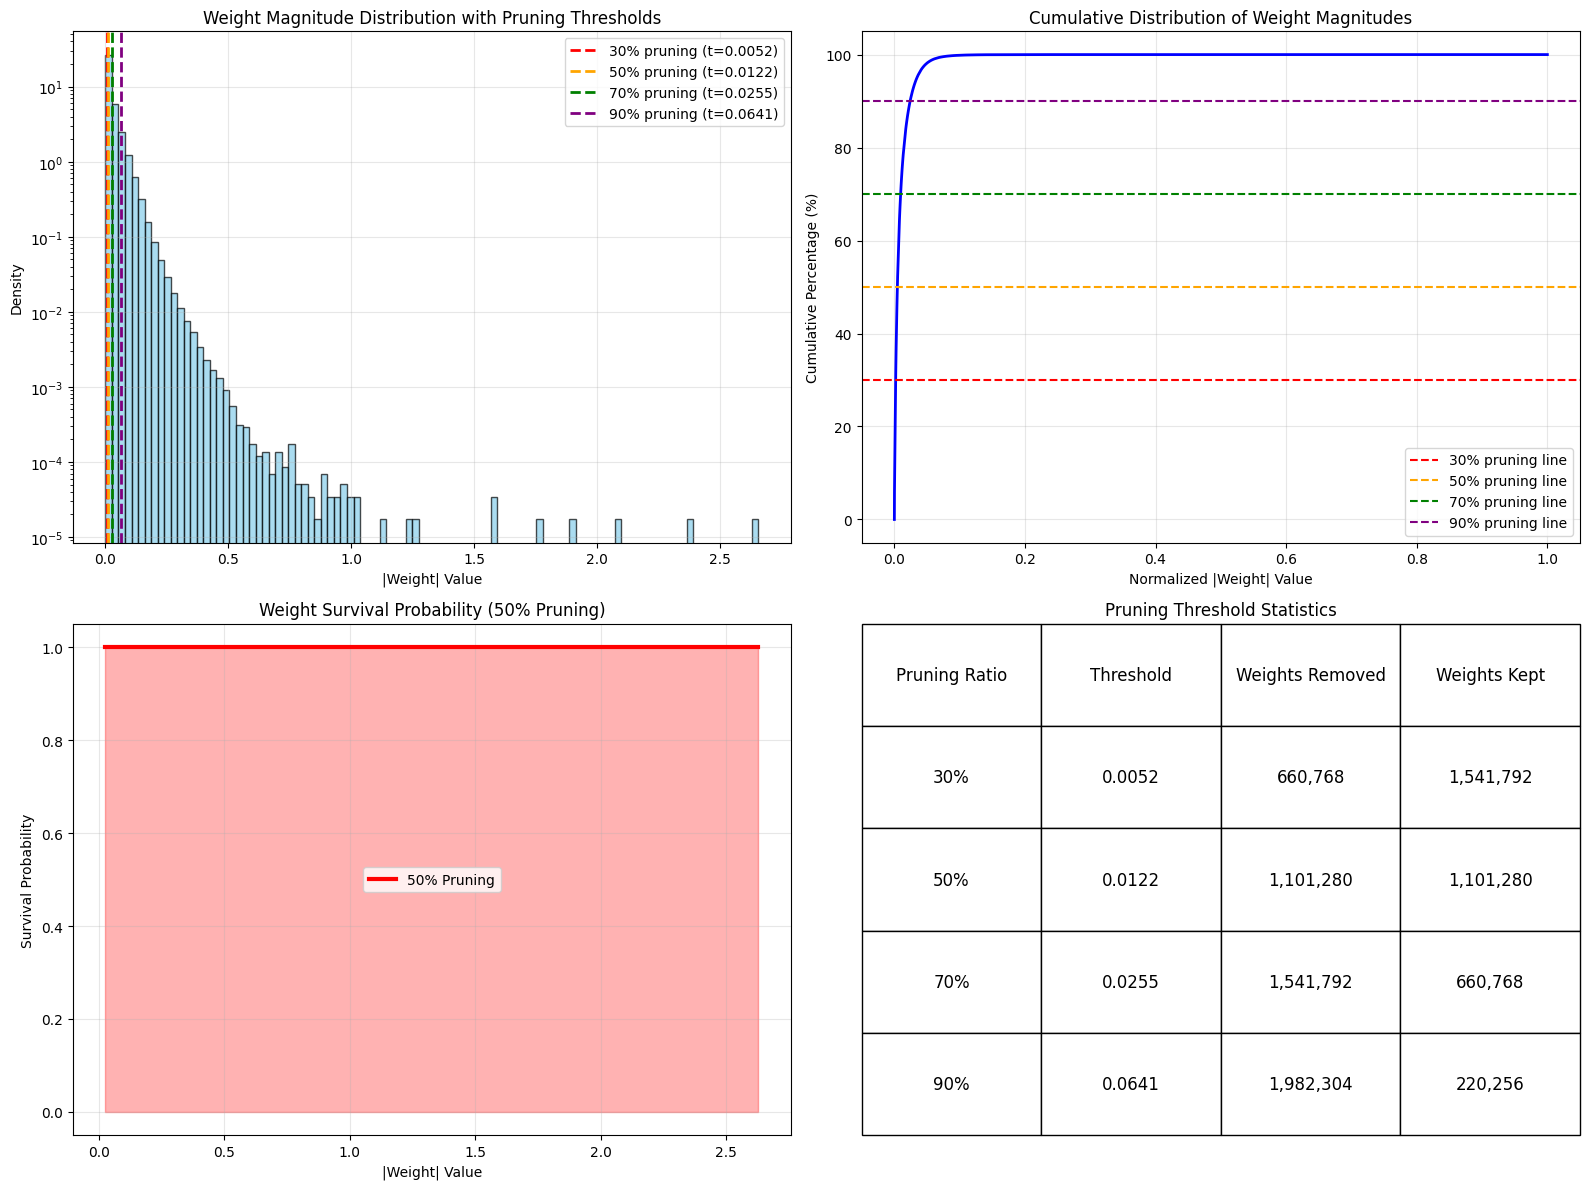


MAGNITUDE-BASED PRUNING THRESHOLD ANALYSIS
Total weights in model: 2,202,560
Weight magnitude range: 0.000000 to 2.655305
Mean absolute weight: 0.024614
Median absolute weight: 0.012206

Pruning Thresholds:
  30% pruning:
    - Threshold: 0.005215
    - Weights pruned: 660,768
    - Weights with |w| < threshold: 30.0%
  50% pruning:
    - Threshold: 0.012206
    - Weights pruned: 1,101,280
    - Weights with |w| < threshold: 50.0%
  70% pruning (Used in Challenge):
    - Threshold: 0.025492
    - Weights pruned: 1,541,792
    - Weights with |w| < threshold: 70.0%
  90% pruning:
    - Threshold: 0.064115
    - Weights pruned: 1,982,304
    - Weights with |w| < threshold: 90.0%


In [14]:
# Analyze magnitude-based pruning thresholds
print("Analyzing magnitude-based pruning thresholds...")
print("This shows how pruning selects weights based on magnitude")

# Collect all weights from the model
all_weights = collect_model_weights(model)
abs_weights = np.abs(all_weights)

# Calculate thresholds for different pruning ratios including our challenge ratio
test_ratios = [0.3, 0.5, PRUNING_RATIO, 0.9]  # Include our challenge ratio
thresholds, sorted_abs_weights = calculate_pruning_thresholds(all_weights, test_ratios)

# Create comprehensive threshold visualization
create_threshold_visualization(abs_weights, sorted_abs_weights, thresholds, test_ratios)

# Print detailed threshold statistics
print(f"\n{'='*80}")
print("MAGNITUDE-BASED PRUNING THRESHOLD ANALYSIS")
print(f"{'='*80}")

print(f"Total weights in model: {len(all_weights):,}")
print(f"Weight magnitude range: {np.min(abs_weights):.6f} to {np.max(abs_weights):.6f}")
print(f"Mean absolute weight: {np.mean(abs_weights):.6f}")
print(f"Median absolute weight: {np.median(abs_weights):.6f}")

print(f"\nPruning Thresholds:")
for ratio in test_ratios:
    threshold = thresholds[ratio]
    num_pruned = int(len(all_weights) * ratio)
    percentage_below = (abs_weights < threshold).mean() * 100
    
    status = " (Used in Challenge)" if ratio == PRUNING_RATIO else ""
    print(f"  {ratio:.0%} pruning{status}:")
    print(f"    - Threshold: {threshold:.6f}")
    print(f"    - Weights pruned: {num_pruned:,}")
    print(f"    - Weights with |w| < threshold: {percentage_below:.1f}%")

In [15]:
# Enhanced layer-wise sparsity analysis
def analyze_layer_sparsity_detailed(model, model_name="Model"):
    """
    Detailed analysis of sparsity in each layer
    """
    layer_info = []
    
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if hasattr(module, 'weight_mask'):
                weight = module.weight * module.weight_mask
            else:
                weight = module.weight
            
            total_params = weight.numel()
            zero_params = (weight == 0).sum().item()
            sparsity = 100.0 * zero_params / total_params
            
            # Additional statistics
            non_zero_weights = weight[weight != 0].detach().cpu().numpy()
            mean_abs_weight = np.mean(np.abs(non_zero_weights)) if len(non_zero_weights) > 0 else 0
            
            layer_info.append({
                'name': name,
                'type': type(module).__name__,
                'shape': list(weight.shape),
                'total_params': total_params,
                'zero_params': zero_params,
                'sparsity': sparsity,
                'mean_abs_weight': mean_abs_weight
            })
    
    print(f"\n{'='*90}")
    print(f"LAYER-WISE SPARSITY ANALYSIS: {model_name}")
    print(f"{'='*90}")
    print(f"{'Layer':<20} {'Type':<8} {'Shape':<15} {'Total':<8} {'Zeros':<8} {'Sparsity':<8} {'Mean |W|':<10}")
    print("-" * 90)
    
    for info in layer_info:
        shape_str = str(info['shape'])
        if len(shape_str) > 14:
            shape_str = shape_str[:11] + "..."
        print(f"{info['name']:<20} {info['type']:<8} {shape_str:<15} "
              f"{info['total_params']:<8} {info['zero_params']:<8} "
              f"{info['sparsity']:<7.1f}% {info['mean_abs_weight']:<10.4f}")
    
    return layer_info

# Compare layer-wise effects between original and pruned models
print("\nComparing layer-wise sparsity between original and pruned models...")

# Analyze original model
original_layer_info = analyze_layer_sparsity_detailed(model, "Original Model")

# Analyze the pruned model from our challenge
pruned_layer_info = analyze_layer_sparsity_detailed(pruned_model, f"{PRUNING_RATIO:.0%} Pruned Model (Challenge)")

print(f"\nKey Observations:")
print(f"- Original model has 0% sparsity across all layers")
print(f"- {PRUNING_RATIO:.0%} pruned model has uniform {PRUNING_RATIO:.0%} sparsity across all layers")
print(f"- Global pruning creates consistent sparsity patterns")
print(f"- Mean weight magnitude increases after pruning (smallest weights removed)")

print("\nLayer-wise sparsity analysis complete!")
print("Global pruning creates uniform sparsity across all layers, as expected.")


Comparing layer-wise sparsity between original and pruned models...

LAYER-WISE SPARSITY ANALYSIS: Original Model
Layer                Type     Shape           Total    Zeros    Sparsity Mean |W|  
------------------------------------------------------------------------------------------
features.0.0         Conv2d   [32, 3, 3, 3]   864      0        0.0    % 0.0792    
features.1.conv.0.0  Conv2d   [32, 1, 3, 3]   288      0        0.0    % 0.2450    
features.1.conv.1    Conv2d   [16, 32, 1, 1]  512      0        0.0    % 0.1477    
features.2.conv.0.0  Conv2d   [96, 16, 1, 1]  1536     0        0.0    % 0.1357    
features.2.conv.1.0  Conv2d   [96, 1, 3, 3]   864      0        0.0    % 0.1318    
features.2.conv.2    Conv2d   [24, 96, 1, 1]  2304     0        0.0    % 0.1265    
features.3.conv.0.0  Conv2d   [144, 24, 1...  3456     0        0.0    % 0.0962    
features.3.conv.1.0  Conv2d   [144, 1, 3, 3]  1296     0        0.0    % 0.1345    
features.3.conv.2    Conv2d   [24, 144

## Step 7: Performance Summary and Comparison

In [16]:
# Create comprehensive results summary for the challenge
def create_results_summary_table():
    """
    Create a comprehensive summary table of challenge pruning results
    """
    print("\n" + "="*80)
    print("                      FINE-GRAINED PRUNING RESULTS SUMMARY")
    print("="*80)
    
    print(f"{'Model':<25} {'Sparsity':<12} {'Accuracy':<12} {'Acc Drop':<12} {'Active Params':<15}")
    print("-" * 85)
    
    # Original model
    print(f"{'Original':<25} {'0.0%':<12} {original_result['accuracy']:<11.2f}% {'0.0%':<12} {original_result['params']:<15,}")
    
    # Pruned model from challenge
    pruned_acc_drop = original_result['accuracy'] - pruned_result['accuracy']
    print(f"{f'{PRUNING_RATIO:.0%} Pruned':<25} {pruned_result['sparsity']:<11.1f}% {pruned_result['accuracy']:<11.2f}% {pruned_acc_drop:<11.2f}% {pruned_result['params']:<15,}")
    
    # Fine-tuned model from challenge
    ft_acc_drop = original_result['accuracy'] - finetuned_result['accuracy']
    print(f"{f'{PRUNING_RATIO:.0%} Pruned + Fine-tuned':<25} {finetuned_result['sparsity']:<11.1f}% {finetuned_result['accuracy']:<11.2f}% {ft_acc_drop:<11.2f}% {finetuned_result['params']:<15,}")

def highlight_key_insights():
    """
    Highlight the key insights from the challenge pruning experiment
    """
    print("\n" + "="*80)
    print("KEY INSIGHTS FROM FINE-GRAINED PRUNING CHALLENGE:")
    print("="*80)
    
    # Calculate key metrics from challenge results
    param_reduction = ((original_result['params'] - finetuned_result['params']) / original_result['params']) * 100
    ft_acc_drop = original_result['accuracy'] - finetuned_result['accuracy']
    recovery = finetuned_result['accuracy'] - pruned_result['accuracy']
    
    print(f"• {PRUNING_RATIO:.0%} pruning reduces active parameters by ~{param_reduction:.0f}% with only {ft_acc_drop:.1f}% final accuracy drop")
    print(f"• Fine-tuning recovers {recovery:.1f}% accuracy after aggressive pruning")
    print(f"• Challenge target: ≥85% accuracy - {'ACHIEVED' if finetuned_result['accuracy'] >= 85 else 'NOT ACHIEVED'}")
    print(f"• Model compression: {original_result['params']:,} → {finetuned_result['params']:,} parameters")
    print(f"• Sparsity achieved: {finetuned_result['sparsity']:.1f}%")
    print(f"• Fine-grained pruning enables efficient model deployment")
    
    print(f"\nPractical Applications:")
    print(f"• Mobile and edge device deployment")
    print(f"• Reducing memory bandwidth requirements")
    print(f"• Enabling larger models on constrained hardware")
    print(f"• Battery life improvement in mobile devices")
    
    print(f"\nNext Steps for Further Optimization:")
    print(f"• Try different pruning ratios (50%, 60%, 80%)")
    print(f"• Experiment with structured pruning for better hardware acceleration")
    print(f"• Combine pruning with quantization for maximum compression")
    print(f"• Test layer-wise sensitivity for strategic pruning")

# Generate the comprehensive summary
create_results_summary_table()
highlight_key_insights()


                      FINE-GRAINED PRUNING RESULTS SUMMARY
Model                     Sparsity     Accuracy     Acc Drop     Active Params  
-------------------------------------------------------------------------------------
Original                  0.0%         87.48      % 0.0%         2,202,570      
70% Pruned                70.0       % 10.00      % 77.48      % 660,778        
70% Pruned + Fine-tuned   70.0       % 82.79      % 4.69       % 660,778        

KEY INSIGHTS FROM FINE-GRAINED PRUNING CHALLENGE:
• 70% pruning reduces active parameters by ~70% with only 4.7% final accuracy drop
• Fine-tuning recovers 72.8% accuracy after aggressive pruning
• Challenge target: ≥85% accuracy - NOT ACHIEVED
• Model compression: 2,202,570 → 660,778 parameters
• Sparsity achieved: 70.0%
• Fine-grained pruning enables efficient model deployment

Practical Applications:
• Mobile and edge device deployment
• Reducing memory bandwidth requirements
• Enabling larger models on constrained hardw